1.Develop Env: linux+cuda9+python3+opencv+pytorch
2.Dataset: ECG-MIT-BIH, https://www.physionet.org/content/mitdb/1.0.0/ 
        AAMI EC57: N-normal heartbeat; S-Supraventricular ectopic beat; V-Ventricular ectopic beat; F-Fushion beat
        Dataset Statistics: 
        trainset：N = 14555， S = 1837, V = 3220, F = 388 (22 subjects)
        testset：N = 14854， S = 944,  V = 3788, F = 414 (22 subjects)
3.Performance Metric: 
  1)Accuracy(Acc):  for evaluating the precison of top 1 in the returned list;
  2)Specificity(Spe): for evaluating the misdiagnosis rate of normal
  3)Sensitivity(Sen): for evaluating the missed diagnosis rate of abnorml(S,V,F)
4.Algorithm: Attention-based Triplet Hashing Network(ATH), Cross-loss(Focal+Triplet)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#read train image with CV
train_dir = '/data/fjsdata/ECG/MIT-BIH/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/fjsdata/ECG/MIT-BIH/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [11]:
#ATH-Triplet Loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, hash_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.hash = nn.Sequential(
            nn.Linear(16*128*128, hash_size),
            nn.ReLU(inplace=True)#nn.Sigmoid()#nn.Tanh()
        )
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x_hash = self.hash(x)
        return x_hash

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
#define model
model = ASHNet(hash_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define triplet loss
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash = model(P_batch.permute(0, 3, 1, 2))
        N_hash = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance with hash
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.0843884Eopch:     1 mean_loss = 2.201908
 2000 / 2000 : loss = 2.8193097Eopch:     2 mean_loss = 0.894042
 2000 / 2000 : loss = 0.088306Eopch:     3 mean_loss = 0.397001
 2000 / 2000 : loss = 0.7511359Eopch:     4 mean_loss = 0.247977
 2000 / 2000 : loss = 0.067857Eopch:     5 mean_loss = 0.211742
 2000 / 2000 : loss = 0.031822Eopch:     6 mean_loss = 0.120529
 2000 / 2000 : loss = 0.0337641Eopch:     7 mean_loss = 0.116483
 2000 / 2000 : loss = 0.014268Eopch:     8 mean_loss = 0.091599
 2000 / 2000 : loss = 0.0417497Eopch:     9 mean_loss = 0.121599
 2000 / 2000 : loss = 0.047742Eopch:    10 mean_loss = 0.055734
best_loss = 0.055734
 1999 / 2000 Completed buliding index in 1 seconds
Accuracy: 0.751500
[[11378   464  2825   187]
 [  331   331   272    10]
 [  352    92  3305    39]
 [  262     1   135    16]]
Specificity: 0.765989
Sensitivity of S: 0.350636
Sensitivity of V: 0.872492
Sensitivity of F: 0.038647


In [17]:
#ATH-CE Loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.dense = nn.Sequential(
            nn.Linear(16*128*128, class_size),
            #nn.ReLU(inplace=True)#nn.Sigmoid()#nn.Tanh()
        )
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x_class = self.dense(x)
        return x_class

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
#define model
model = ASHNet(class_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_batch.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.018829Eopch:     1 mean_loss = 0.179908
 2000 / 2000 : loss = 0.028544Eopch:     2 mean_loss = 0.047202
 2000 / 2000 : loss = 0.000724Eopch:     3 mean_loss = 0.020276
 2000 / 2000 : loss = 0.001304Eopch:     4 mean_loss = 0.015025
 2000 / 2000 : loss = 0.055858Eopch:     5 mean_loss = 0.011000
 2000 / 2000 : loss = 0.001074Eopch:     6 mean_loss = 0.008110
 2000 / 2000 : loss = 9.2e-056Eopch:     7 mean_loss = 0.003257
 2000 / 2000 : loss = 0.000713Eopch:     8 mean_loss = 0.002618
 2000 / 2000 : loss = 5.7e-053Eopch:     9 mean_loss = 0.004282
 2000 / 2000 : loss = 0.006657Eopch:    10 mean_loss = 0.001906
best_loss = 0.001906
 1999 / 2000 Accuracy: 0.766200
[[11921   263  2636    34]
 [  501   210   233     0]
 [  483   104  3193     8]
 [  306     4   104     0]]
Specificity: 0.802545
Sensitivity of S: 0.222458
Sensitivity of V: 0.842925
Sensitivity of F: 0.000000


In [18]:
#Resnet CE Loss
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #fully connected
        self.dense = nn.Sequential(
            nn.Linear(16*128*128, class_size),
            #nn.ReLU(inplace=True)#nn.Sigmoid()#nn.Tanh()
        )
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0),-1)
        x_class = self.dense(x)
        return x_class

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
#define model
model = ResNet(class_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_batch.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.009352Eopch:     1 mean_loss = 0.365388
 2000 / 2000 : loss = 0.130224Eopch:     2 mean_loss = 0.055437
 2000 / 2000 : loss = 0.000106Eopch:     3 mean_loss = 0.033067
 2000 / 2000 : loss = 3e-06057Eopch:     4 mean_loss = 0.025777
 2000 / 2000 : loss = 0.000155Eopch:     5 mean_loss = 0.016148
 2000 / 2000 : loss = 4e-06491Eopch:     6 mean_loss = 0.015006
 2000 / 2000 : loss = 2.3e-057Eopch:     7 mean_loss = 0.008080
 2000 / 2000 : loss = 3e-06507Eopch:     8 mean_loss = 0.010156
 2000 / 2000 : loss = 5e-06156Eopch:     9 mean_loss = 0.004989
 2000 / 2000 : loss = 8.4e-052Eopch:    10 mean_loss = 0.006018
best_loss = 0.004989
 1999 / 2000 Accuracy: 0.718300
[[10663   371  3790    30]
 [  411   163   369     1]
 [  220    25  3540     3]
 [  266     5   143     0]]
Specificity: 0.717854
Sensitivity of S: 0.172669
Sensitivity of V: 0.934530
Sensitivity of F: 0.000000


In [19]:
#Resnet Focal Loss
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #fully connected
        self.dense = nn.Sequential(
            nn.Linear(16*128*128, class_size),
            #nn.ReLU(inplace=True)#nn.Sigmoid()#nn.Tanh()
        )
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0),-1)
        x_class = self.dense(x)
        return x_class

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
#https://github.com/marvis/pytorch-yolo2/blob/master/FocalLoss.py
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
        
#define model
model = ResNet(class_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = FocalLoss(gamma=2,alpha=[0.7,0.1,0.15,0.05]).cuda() #define focal loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_batch.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.004956Eopch:     1 mean_loss = 0.065076
 2000 / 2000 : loss = 0.000564Eopch:     2 mean_loss = 0.004498
 2000 / 2000 : loss = 0.000259Eopch:     3 mean_loss = 0.002403
 2000 / 2000 : loss = 2e-06103Eopch:     4 mean_loss = 0.003098
 2000 / 2000 : loss = 0.000245Eopch:     5 mean_loss = 0.003271
 2000 / 2000 : loss = 0.001885Eopch:     6 mean_loss = 0.001760
 2000 / 2000 : loss = 1.4e-053Eopch:     7 mean_loss = 0.000738
 2000 / 2000 : loss = 0.050783Eopch:     8 mean_loss = 0.030995
 2000 / 2000 : loss = 0.000288Eopch:     9 mean_loss = 0.003126
 2000 / 2000 : loss = 4e-06056Eopch:    10 mean_loss = 0.000267
best_loss = 0.000267
 1999 / 2000 Accuracy: 0.775100
[[12489   127  2227    11]
 [  642    99   202     1]
 [  754   117  2914     3]
 [  355     0    59     0]]
Specificity: 0.840784
Sensitivity of S: 0.104873
Sensitivity of V: 0.769271
Sensitivity of F: 0.000000


Org data dimension is 36.Embedded data dimension is 2


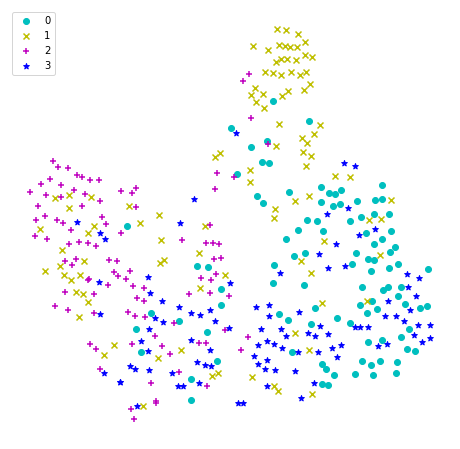

In [12]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()[0:100]
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()[0:100]
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()[0:100]
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()[0:100]
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

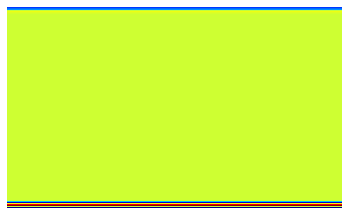

In [14]:
#feature map
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
 
# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

image_path = '/data/tmpexec/ecg/test/9929-2.png' #V:Ventricular ectopic beat
oriImg = cv2.imread(image_path)
height, width, _ = oriImg.shape
#plt.axis('off')
#plt.imshow(oriImg)
data = []
oriImg = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
data.append(oriImg)
data = torch.from_numpy(np.array(data)).type(torch.FloatTensor).cuda() 

activation = {}
best_net.sa.register_forward_hook(get_activation('sa'))#spatial attention
output = best_net(data.permute(0, 3, 1, 2))
feature = activation['sa'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(featuremap)

In [ ]:
'''
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py   
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
'''        

In [ ]:
'''
#define FocalLoss gamma=[0,0.5,1,2,5] alpha=[0.25,0.25,0.25,0.25,0.25]
criterion  = FocalLoss(gamma=2).cuda() 
#train model with focal loss
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        _, out_class = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_class, y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
'''

In [ ]:
'''
#performance with class
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    _, out_class = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_class.cpu().data.numpy().tolist()) #record feature
    out_class = F.log_softmax(out_class,dim=1) 
    pred = out_class.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
'''

In [8]:
#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance with hash
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 1999 / 2000 Completed buliding index in 24 seconds
mHR@5=0.767000, mAP@5=0.755568, mRR@5=0.969637
mHR@10=0.767155, mAP@10=0.752808, mRR@10=0.959251
mHR@15=0.766840, mAP@15=0.751467, mRR@15=0.952275
mHR@20=0.766660, mAP@20=0.750577, mRR@20=0.948231
 1999 / 2000 Accuracy: 0.619650
[[8303 1254 4892  397    0]
 [ 149  350  430   15    0]
 [  26   10 3687   65    0]
 [ 165    8  188   53    0]
 [   0    2    6    0    0]]
Specificity: 0.559275
Sensitivity of S: 0.370763
Sensitivity of V: 0.973337
Sensitivity of F: 0.128019
Sensitivity of Q: 0.000000


In [18]:
#test network: valid
xq = torch.rand(10,3,256,256).cuda()
xp = torch.rand(10,3,256,256).cuda()
xn = torch.rand(10,3,256,256).cuda()
model = ASHNet(hash_size=36, class_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define pairwise loss
for epoch in range(10):
    optimizer.zero_grad()
    
    outq,_ = model(xq)#out.grad_fn
    outp,_ = model(xp)
    outn,_ = model(xn)
    loss = criterion(outq,outp,outn)
    print (loss.item())
    loss.backward()
    optimizer.step()
    #observe the variant of model.parameters
    for i in model.named_parameters():
        print(i[0])
        print(i[1][0][0][0])
        break
#output
x = torch.rand(10,3,256,256).cuda()
out,_ = model(x)
#out = torch.sign(out) #Binarization,[-1,1]->{-1,1}
print (out.size())
x = x.cpu()
xq = xq.cpu()
xp = xp.cpu()
xn = xn.cpu()
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()

18.000080108642578
net.0.net.0.weight
tensor([0.1009, 0.1183, 0.0598], device='cuda:0', grad_fn=<SelectBackward>)
17.973249435424805
net.0.net.0.weight
tensor([0.1016, 0.1175, 0.0605], device='cuda:0', grad_fn=<SelectBackward>)
17.716821670532227
net.0.net.0.weight
tensor([0.1024, 0.1167, 0.0607], device='cuda:0', grad_fn=<SelectBackward>)
17.584300994873047
net.0.net.0.weight
tensor([0.1027, 0.1160, 0.0608], device='cuda:0', grad_fn=<SelectBackward>)
17.504169464111328
net.0.net.0.weight
tensor([0.1026, 0.1154, 0.0610], device='cuda:0', grad_fn=<SelectBackward>)
17.44349479675293
net.0.net.0.weight
tensor([0.1025, 0.1150, 0.0611], device='cuda:0', grad_fn=<SelectBackward>)
17.424943923950195
net.0.net.0.weight
tensor([0.1025, 0.1145, 0.0611], device='cuda:0', grad_fn=<SelectBackward>)
17.4094181060791
net.0.net.0.weight
tensor([0.1024, 0.1139, 0.0610], device='cuda:0', grad_fn=<SelectBackward>)
17.38896369934082
net.0.net.0.weight
tensor([0.1023, 0.1132, 0.0609], device='cuda:0', grad

In [2]:
#Beats generation,
#we defined a single ECG beat image by centering the Q-wave peak signal while
#excluding the first and the last 20 ECG signals from the previous and afterward Q-wave peak signal
#https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
#https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
#http://www.tara.tcd.ie/bitstream/handle/2262/17623/automatic.pdf?sequence=1
def labeltotext(val):
    if val in ['N','L','R','e','j'] :
        return 0 #N
    elif val in ['A','a','J','S']:
        return 1 #S
    elif val in ['V','E']:
        return 2 #V
    elif val == 'F':
        return 3 #F
    else: 
        pass
    
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 180 #left sample length around of peak value of QRS
#get trainset
trData = [] #[QRS value, label]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]:#22 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    trData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass
    
NOR = 14854 #normal samples    
trData = pd.DataFrame(np.array(trData))
NData =  trData[trData[1]==0].sample(n=NOR, random_state=1)
UNData = trData[trData[1]!=0]
trData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS1 = pd.DataFrame(trData[0].values.tolist())
y_DS1 = trData[1]
print('The shape of DS1 is: (%d,%d)'%(X_DS1.shape[0],X_DS1.shape[1]))
print(trData[1].value_counts())

#get testset
teData = [] #[QRS value, label]
for bt in [100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:#22 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    teData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass

NOR = 14555 #normal samples    
teData = pd.DataFrame(np.array(teData))
NData =  teData[teData[1]==0].sample(n=NOR, random_state=1)
UNData = teData[teData[1]!=0]
teData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS2 = pd.DataFrame(teData[0].values.tolist())
y_DS2 = teData[1]
print('The shape of DS2 is: (%d,%d)'%(X_DS2.shape[0],X_DS2.shape[1]))
print(teData[1].value_counts())

#model: faiss+index
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(right_len+left_len) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(X_DS2, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(X_DS1, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(y_DS2)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_DS1.tolist(), y_pred))
#confusion matrix
labels = list(set(y_DS1))
cm = confusion_matrix(y_DS1.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

The shape of DS1 is: (20000,360)
0    14854
2     3788
1      944
3      414
Name: 1, dtype: int64
The shape of DS2 is: (20000,360)
0    14555
2     3220
1     1837
3      388
Name: 1, dtype: int64
Completed buliding index in 24 seconds
Accuracy: 0.807700
[[12810   419  1340   285]
 [  638   148   151     7]
 [  518    79  3158    33]
 [  277     1    98    38]]
Specificity: 0.862394
Sensitivity of S: 0.156780
Sensitivity of V: 0.833685
Sensitivity of F: 0.091787


In [3]:
#import ecg_plot#pip install ecg_plot, https://pypi.org/project/ecg-plot/
#from scipy.misc import electrocardiogram 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html
fs = 360
for idx,row in X_DS2.iterrows():
    label = np.array(y_DS2)[idx]
    svpath = os.path.join('/data/fjsdata/ECG/MIT-BIH/train',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS2.shape[0]))
    sys.stdout.flush()
for idx,row in X_DS1.iterrows():
    label = np.array(y_DS1)[idx]
    svpath = os.path.join('/data/fjsdata/ECG/MIT-BIH/test',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS1.shape[0]))
    sys.stdout.flush()

19999 / 20000 